In [1]:
import numpy as np

def softmax(x, axis = 0):
  return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis = axis), axis)

### Calculating alignment scores

Measure of similarity between the decoder hidden state and each encoder hidden state. From the paper, this operation looks like

$$
\large e_{ij} = v_a^\top \tanh{\left(W_a s_{i-1} + U_a h_j\right)}
$$

Here $h_j$ are the encoder hidden states for each input step $j$ and $s_{i - 1}$ is the decoder hidden state of the previous step. The first layer corresponds to $W_a$ and $U_a$, while the second layer corresponds to $v_a$.

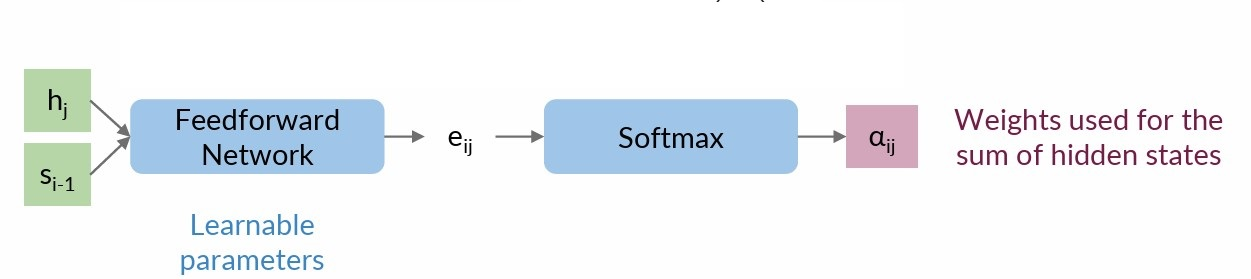


In [6]:
hidden_size = 16
attention_size = 10
input_length = 5

np.random.seed(5)

# Synthetic vectors used to test
encoder_states = np.random.randn(input_length, hidden_size)
decoder_state = np.random.randn(1, hidden_size)

# Weights for the neural network, these are typically learned through training
layer_1 = np.random.randn(2 * hidden_size, attention_size)
layer_2 = np.random.randn(attention_size, 1)

def alignment(encoder_states, decoder_state):
  # First, concatenate the encoder states and the decoder state
  # decoder_state = np.array([1, 2, 3]), input_length = 4
  # decoder_state.repeat(input_length, axis=0) -> array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])
  inputs = np.concatenate((encoder_states, decoder_state.repeat(input_length, axis = 0)), axis = 1)
  assert inputs.shape == (input_length, 2 * hidden_size)

  # Matrix multiplication of the concatenated inputs and layer_1, with tanh activation function
  activations = np.tanh(np.dot(inputs, layer_1))
  assert activations.shape == (input_length, attention_size)

  # Matrix multiplication of the activations with the second layer
  scores = np.dot(activations, layer_2)
  assert scores.shape == (input_length, 1)

  return scores

# Run this to test the alignment function
scores = alignment(encoder_states, decoder_state)
print(scores)

[[ 1.23131244]
 [-1.68354855]
 [ 3.38461058]
 [ 1.11258584]
 [ 2.94867728]]


### Turning alignment into weights
Calculate the weights from the alignment scores. These weights determine the encoder outputs that are the most important for the decoder output. These weights should be between 0 and 1. You can use the softmax function (which is already implemented above) to get these weights from the attention scores. Pass the attention scores vector to the softmax function to get the weights. Mathematically,

$$
\large \alpha_{ij} = \frac{\exp{\left(e_{ij}\right)}}{\sum_{k=1}^K \exp{\left(e_{ik}\right)}}
$$

### Weight the encoder output vectors and sum

The weights tell you the importance of each input word with respect to the decoder state. In this step, you use the weights to modulate the magnitude of the encoder vectors. Words with little importance will be scaled down relative to important words. Multiply each encoder vector by its respective weight to get the alignment vectors, then sum up the weighted alignment vectors to get the context vector. Mathematically,


$$
\large c_i = \sum_{j=1}^K\alpha_{ij} h_{j}
$$



In [15]:
def attention(encoder_states, decoder_state):
  # First, calculate the dot product of each encoder vector with the decoder vector
  scores = alignment(encoder_states, decoder_state)

  # Then take the softmax function of those scores to get a weight distribution
  weights = softmax(scores)

  # Multiply each encoder state by its respective weight
  weighted_scores = encoder_states * weights

  # Sum up the weights encoder states
  context = np.sum(weighted_scores, axis = 0)

  return context

# Run this to test the attention function
context = attention(encoder_states, decoder_state)
print(context)

[ 0.20563992 -0.06939324  0.60627308  0.10641746 -0.95086987  1.04293432
 -0.78611427  1.39092539  0.47482928 -0.2962707  -0.38609858 -0.2997607
  0.39919798  0.71088685  0.28806183  0.08909197]
